In [ ]:
! python3 -m pip install paddlepaddle -i https://mirror.baidu.com/pypi/simple

In [ ]:
! pip install "paddleocr>=2.0.1" 

In [53]:
import matplotlib.pylab as plt
import cv2
import numpy as np
import os
import pandas as pd
from paddleocr import PaddleOCR, draw_ocr

In [56]:
# Paddleocr目前支持的多语言语种可以通过修改lang参数进行切换
# 例如`ch`, `en`, `fr`, `german`, `korean`, `japan`
ocr = PaddleOCR(use_angle_cls=True, lang="en")  # need to run only once to download and load model into memory

[2022/10/14 06:37:48] ppocr DEBUG: Namespace(alpha=1.0, benchmark=False, beta=1.0, cls_batch_num=6, cls_image_shape='3, 48, 192', cls_model_dir='/root/.paddleocr/whl/cls/ch_ppocr_mobile_v2.0_cls_infer', cls_thresh=0.9, cpu_threads=10, crop_res_save_dir='./output', det=True, det_algorithm='DB', det_db_box_thresh=0.6, det_db_score_mode='fast', det_db_thresh=0.3, det_db_unclip_ratio=1.5, det_east_cover_thresh=0.1, det_east_nms_thresh=0.2, det_east_score_thresh=0.8, det_fce_box_type='poly', det_limit_side_len=960, det_limit_type='max', det_model_dir='/root/.paddleocr/whl/det/en/en_PP-OCRv3_det_infer', det_pse_box_thresh=0.85, det_pse_box_type='quad', det_pse_min_area=16, det_pse_scale=1, det_pse_thresh=0, det_sast_nms_thresh=0.2, det_sast_polygon=False, det_sast_score_thresh=0.5, draw_img_save_dir='./inference_results', drop_score=0.5, e2e_algorithm='PGNet', e2e_char_dict_path='./ppocr/utils/ic15_dict.txt', e2e_limit_side_len=768, e2e_limit_type='max', e2e_model_dir=None, e2e_pgnet_mode='f

# 載入影像

In [65]:
def dist_2_pts(x1, y1, x2, y2):
    #print np.sqrt((x2-x1)^2+(y2-y1)^2)
    return np.sqrt((x2 - x1)**2 + (y2 - y1)**2)

def pos_2_angle(x,y,x1,y1,x2,y2):
    dist_pt0 = dist_2_pts(x,y,x1,y1)
    dist_pt1 = dist_2_pts(x,y,x2,y2)
    if (dist_pt0 > dist_pt1):
        xlen= x1-x
        ylen= y-y1
    else:
        xlen= x2-x
        ylen= y-y2
        
    #Taking arc-tan of ylen/xlen to find the angle
    res= np.arctan(np.divide(float(abs(ylen)), float(abs(xlen))))
    res= np.rad2deg(res)
    final_angle  =0
    if xlen<0 and ylen>0:                 #Quadrant 1
        final_angle= res+90
    if xlen>0 and ylen>0:                 #Quadrant 2
        final_angle= 270-res
    if xlen>0 and ylen<0:                 #Quadrant 3
        final_angle= 270+res
    if xlen<0 and ylen<0:                 #Quadrant 4
        final_angle= 90-res
   
    return final_angle

def is_number(s):
    try:  # 如果能运行float(s)语句，返回True（字符串s是浮点数）
        float(s)
        return True
    except ValueError:  # ValueError为Python的一种标准异常，表示"传入无效的参数"
        pass  # 如果引发了ValueError这种异常，不做任何事情（pass：不做任何事情，一般用做占位语句）
    try:
        import unicodedata  # 处理ASCii码的包
        unicodedata.numeric(s)  # 把一个表示数字的字符串转换为浮点数返回的函数
        return True
    except (TypeError, ValueError):
        pass
    return False

"""
X=(gb-cf)\(eb-af)

Y=(ag-ce)\(af-be)

R=sqrt((X-x1)*(X-x1)+(Y-y1)*(Y-y1))
"""

def get_circle(p1,p2,p3):
    '''三点求圆，返回圆心和半径'''
    x, y, z = p1[0]+p1[1]*1j, p2[0]+p2[1]*1j, p3[0]+p3[1]*1j
    w = z-x
    w /= y-x
    c = (x-y)*(w-abs(w)**2)/2j/w.imag-x 
    return (-c.real,-c.imag),abs(c+x)


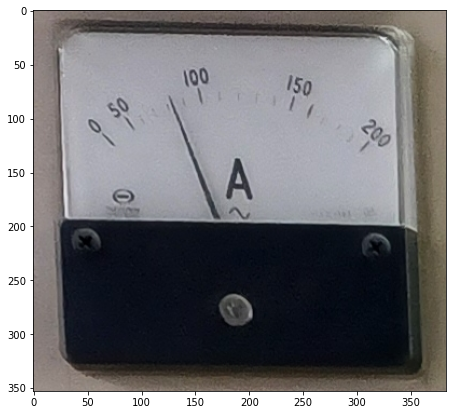

In [212]:
img= cv2.imread('/content/11A.jpg')[:,:,::-1]

height, width= img.shape[:2]
plt.figure(figsize=(10,7))
plt.imshow(img)
gray= cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) #Convert to gray


# 找圓型

[2022/10/14 08:17:59] ppocr DEBUG: dt_boxes num : 7, elapse : 0.1439955234527588
[2022/10/14 08:17:59] ppocr DEBUG: cls num  : 7, elapse : 0.0603487491607666
[2022/10/14 08:18:00] ppocr DEBUG: rec_res num  : 7, elapse : 0.5639965534210205


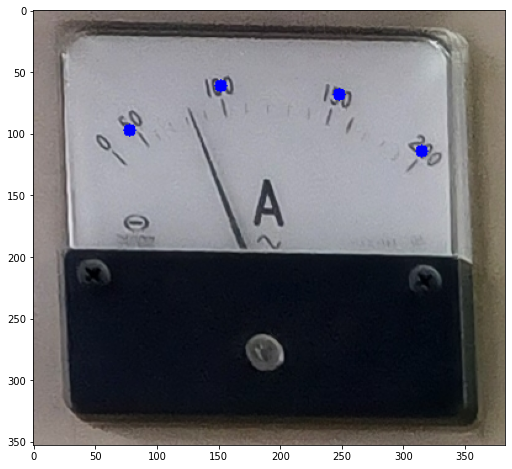

In [213]:
results = ocr.ocr(img, cls=True)[0]
threshold = 0.0
pos_list = []
for result in results: 
    # print(result)
    if is_number(result[1][0]): 
        pos_list.append([result[0],int(result[1][0]),result[1][1]])
        
pos_list = np.array(pos_list)
pos_list = pos_list[pos_list[:,1].argsort()]
t = img.copy()
plt.figure(figsize=(12,8))
for pos in pos_list:
    t = cv2.circle(t, (int((pos[0][0][0]+pos[0][1][0])/2),int((pos[0][0][1]+pos[0][3][1])/2)), radius=5, color=(0, 0, 255), thickness=-1)

plt.imshow(t)

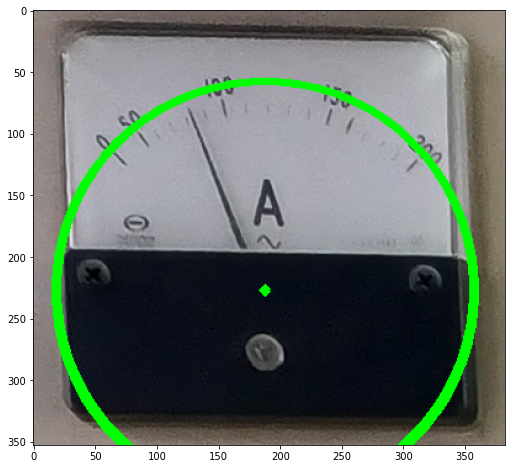

In [214]:
# 推估圓形位置
import itertools
# 排列組合3點座標
indices = [i for i in range(len(pos_list))]
inp_list = indices
permutations = list(itertools.combinations(inp_list, r=3))
circle_of_interest = []
for i, permutation in enumerate(permutations):
    pos1,pos2,pos3 = permutation
    x1=(pos_list[pos1][0][0][0]+pos_list[pos1][0][1][0])/2
    y1=(pos_list[pos1][0][0][1]+pos_list[pos1][0][3][1])/2

    x2=(pos_list[pos2][0][0][0]+pos_list[pos2][0][1][0])/2
    y2=(pos_list[pos2][0][0][1]+pos_list[pos2][0][3][1])/2

    x3=(pos_list[pos3][0][0][0]+pos_list[pos3][0][1][0])/2
    y3=(pos_list[pos3][0][0][1]+pos_list[pos3][0][3][1])/2

    #print((x1,y1),(x2,y2),(x3,y3))
    c,r = get_circle((x1,y1),(x2,y2),(x3,y3))
    c1,c2 = c
    circle_of_interest.append([c1,c2,r])
    #print(c,r)

t = img.copy()
plt.figure(figsize=(12,8))
for pos in circle_of_interest[:]:
    t = cv2.circle(t, (int(pos[0]), int(pos[1])),int(pos[2]),(0,255,0), 3)
    t = cv2.circle(t, (int(pos[0]), int(pos[1])),int(2),(0,255,0), 3)
plt.imshow(t)

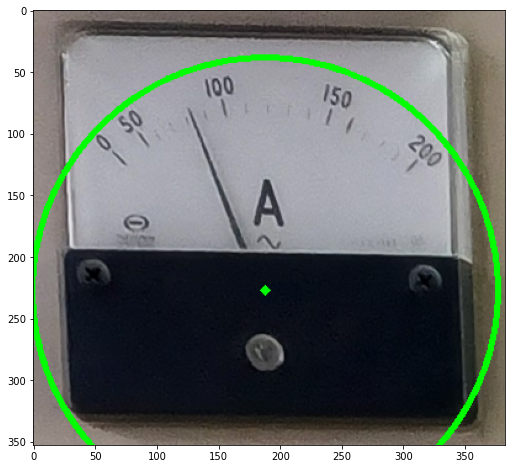

In [215]:
x = np.array(circle_of_interest)[:,0].mean()
y = np.array(circle_of_interest)[:,1].mean()
r = np.array(circle_of_interest)[:,2].mean()+20
t2 = img.copy()
plt.figure(figsize=(12,8))
t2 = cv2.circle(t2, (int(x), int(y)), int(r), (0,255,0), 3)
t2 = cv2.circle(t2, (int(x), int(y)), int(2), (0,255,0), 3)
plt.imshow(t2)

# 標示圓型度數

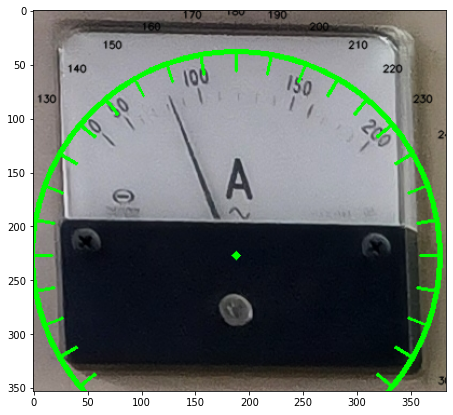

In [216]:
separation= 10 #in degrees
interval = int(360/separation)
p1 = np.zeros((interval,2))  #set empty arrays
p2 = np.zeros((interval,2))
p_text = np.zeros((interval,2))

# 計算圓上點座標，已知半徑、圓心，x1 = x0 + r * cos(angle * PI / 180) y1 = y0 + r * sin(angle * PI /180)
for i in range(0,interval):
    for j in range(0,2):
        if (j%2==0):
            p1[i][j] = x + 0.9 * r * np.cos(separation * i * np.pi / 180) # angle = separation * i
        else:
            p1[i][j] = y + 0.9 * r * np.sin(separation * i * np.pi / 180)

text_offset_x = 10
text_offset_y = 5

for i in range(0, interval):
    for j in range(0, 2):
        if (j % 2 == 0):
            p2[i][j] = x + r * np.cos(separation * i * np.pi / 180)
            p_text[i][j] = x - text_offset_x + 1.2 * r * np.cos((separation) * (i+9) * np.pi / 180) #point for text labels, i+9 rotates the labels by 90 degrees
        else:
            p2[i][j] = y + r * np.sin(separation * i * np.pi/ 180)
            p_text[i][j] = y + text_offset_y + 1.2* r * np.sin((separation) * (i+9) * np.pi / 180)  # point for text labels, i+9 rotates the labels by 90 degrees

#add the lines and labels to the image
for i in range(0,interval):
    cv2.line(t2, (int(p1[i][0]), int(p1[i][1])), (int(p2[i][0]), int(p2[i][1])),(0, 255, 0), 2)
    cv2.putText(t2, '%s' %(int(i*separation)), (int(p_text[i][0]), int(p_text[i][1])), cv2.FONT_HERSHEY_SIMPLEX, 0.3,(0,0,0),1,cv2.LINE_AA)

plt.figure(figsize=(10,7))
plt.imshow(t2)

# 找尋起始值與最終值

In [217]:
# 先把輪廓找出來
separation= 10 #in degrees
interval = int(360/separation)
p3 = np.zeros((interval,2))  #set empty arrays
p4 = np.zeros((interval,2))

for i in range(0,interval):
    for j in range(0,2):
        if (j%2==0):
            p3[i][j] = x + 1 *  r * np.cos(separation * i * np.pi / 180) #point for lines
        else:
            p3[i][j] = y + 1 *  r * np.sin(separation * i * np.pi / 180)


region_of_interest_vertices= p3

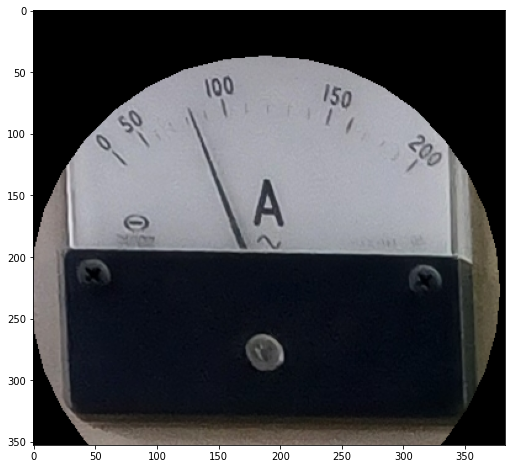

In [218]:
# 遮蔽背景，以方便找出輪廓
def region_of_interest(img, vertices):
    mask= np.zeros_like(img)
    match_mask_color= (255, 255, 255) # White color
    cv2.fillPoly(mask, vertices, match_mask_color)
    masked_image= cv2.bitwise_and(img, mask)
    return masked_image

region_of_interest_vertices= p3
cropped_image= region_of_interest(img, np.array([region_of_interest_vertices], np.int64))
plt.figure(figsize=(10,8))
plt.imshow(cropped_image)

[2022/10/14 08:18:19] ppocr DEBUG: dt_boxes num : 7, elapse : 0.13168001174926758
[2022/10/14 08:18:19] ppocr DEBUG: cls num  : 7, elapse : 0.0614476203918457
[2022/10/14 08:18:20] ppocr DEBUG: rec_res num  : 7, elapse : 0.5908050537109375


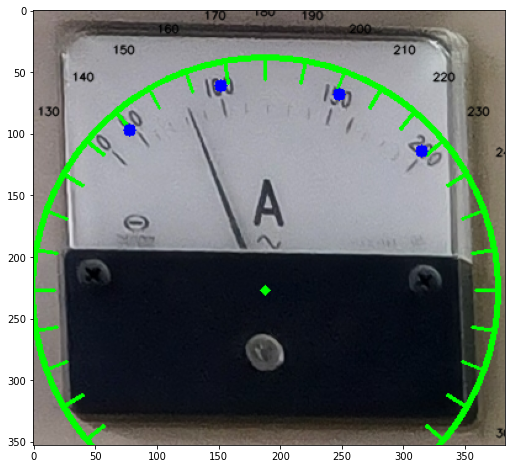

In [219]:
results = ocr.ocr(img, cls=True)[0]
threshold = 0.0
pos_list = []
for result in results: 
    if is_number(result[1][0]) and result[1][1]>=threshold: 
        pos_list.append([result[0],int(result[1][0]),result[1][1]])
        
pos_list = np.array(pos_list)
pos_list = pos_list[pos_list[:,1].argsort()]

t3 = t2.copy()
plt.figure(figsize=(12,8))
for pos in pos_list:
    t3 = cv2.circle(t3, (int((pos[0][0][0]+pos[0][1][0])/2),int((pos[0][0][1]+pos[0][3][1])/2)), radius=5, color=(0, 0, 255), thickness=-1)

plt.imshow(t3)

In [220]:
# 起始值、最終值中心座標
min_value_pos = [(pos_list[0][0][0][0]+pos_list[0][0][1][0])/2,(pos_list[0][0][0][1]+pos_list[0][0][3][1])/2]
max_value_pos = [(pos_list[-1][0][0][0]+pos_list[-1][0][1][0])/2,(pos_list[-1][0][0][1]+pos_list[-1][0][3][1])/2]

# 起始值、最終值
min_value = pos_list[0][1]
max_value = pos_list[-1][1]

# 起始值、最終值座標轉角度
min_angle = pos_2_angle(x,y,x,y,min_value_pos[0],min_value_pos[1])
max_angle = pos_2_angle(x,y,x,y,max_value_pos[0],max_value_pos[1])

print(f'real max_value {max_value}')
print(f'real min_value {min_value}')

print(f'real max_angle {max_angle}')
print(f'real min_angle {min_angle}')

real max_value 200
real min_value 50
real max_angle 228.28746212600595
real min_angle 139.82795296620623


In [211]:
pos_list

array([[list([[165.0, 217.0], [185.0, 217.0], [185.0, 235.0], [165.0, 235.0]]),
        2, 0.9325995445251465],
       [list([[73.0, 154.0], [92.0, 154.0], [92.0, 175.0], [73.0, 175.0]]),
        11, 0.575432538986206],
       [list([[81.0, 126.0], [105.0, 124.0], [108.0, 157.0], [84.0, 159.0]]),
        20, 0.9990520477294922],
       [list([[161.0, 102.0], [181.0, 102.0], [181.0, 125.0], [161.0, 125.0]]),
        40, 0.9982617497444153],
       [list([[242.0, 122.0], [263.0, 122.0], [263.0, 146.0], [242.0, 146.0]]),
        60, 0.9608294367790222]], dtype=object)

# 找指針

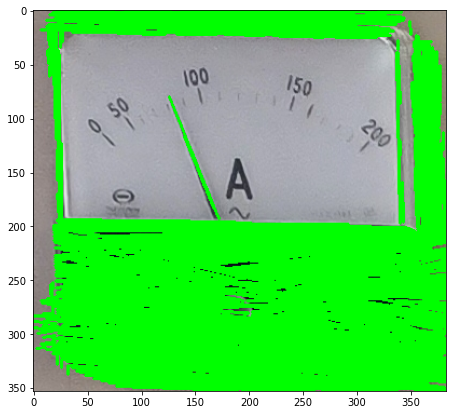

In [221]:
minLineLength = 10
maxlineGap   = 8

output1 = img.copy()
th, dst2 = cv2.threshold(gray, 127, 255, cv2.THRESH_BINARY_INV)

lines = cv2.HoughLinesP(dst2, 1, np.pi / 180, 100, minLineLength, maxlineGap)
#Visualize the lines
for line in lines:
    x1, y1, x2, y2 =line[0]

    cv2.line(output1, (x1, y1), (x2, y2), (0,255,0), 2)
plt.figure(figsize=(10,7))
plt.imshow(output1)


(140, 117, 167, 183)
(126, 80, 172, 193)


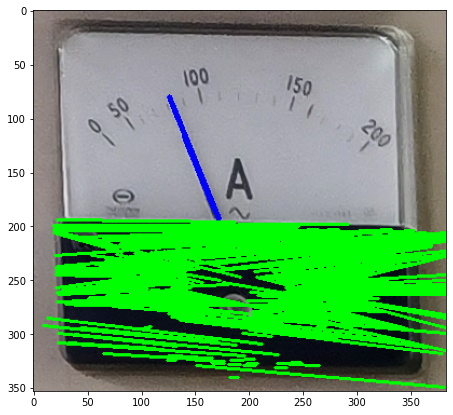

In [222]:
# 指定取得指針的Y範圍
Pointer_field_view_Y = height/2

final_line_list = []
#print "radius: %s" %r
output6= img.copy()
# 線不能比半徑r長or短
diff1LowerBound = 0.0 #diff1LowerBound and diff1UpperBound determine how close the line should be from the center
diff1UpperBound = 0.6
diff2LowerBound = 0.3 #diff2LowerBound and diff2UpperBound determine how close the other point of the line should be to the outside of the gauge
diff2UpperBound = 1.3
for i in range(0, len(lines)):
    for x1, y1, x2, y2 in lines[i]:
     
        diff1 = dist_2_pts(x, y, x1, y1)  # x, y is center of circle
        diff2 = dist_2_pts(x, y, x2, y2)  # x, y is center of circle
        #set diff1 to be the smaller (closest to the center) of the two), makes the math easier
        if (diff1 > diff2):
            temp = diff1
            diff1 = diff2
            diff2 = temp
        # check if line is within an acceptable range
       
        if (((diff1<diff1UpperBound*r) and (diff1>diff1LowerBound*r) and (diff2<diff2UpperBound*r)) and (diff2>diff2LowerBound*r)) :           
                line_length = dist_2_pts(x1, y1, x2, y2)
                final_line_list.append([x1, y1, x2, y2, line_length])

final_line_list = np.array(final_line_list, dtype=np.int64) 
final_line_list = final_line_list[final_line_list[:, 4].argsort()]

for i in range(len(final_line_list)):
    x1 = final_line_list[i,0]
    y1 = final_line_list[i,1]
    x2 = final_line_list[i,2]
    y2 = final_line_list[i,3]
    if y1 <= Pointer_field_view_Y :
        cv2.line(output6, (x1, y1), (x2, y2), (0, 0, 255), 3)
        
        final_line = x1, y1, x2, y2
        print(final_line)
    else:
        cv2.line(output6, (x1, y1), (x2, y2), (0, 255, 0), 2)
plt.figure(figsize=(10,7))
plt.imshow(output6)

In [223]:
final_line

(126, 80, 172, 193)

In [224]:
# 計算指針角度
x1,y1,x2,y2 = final_line
final_angle = pos_2_angle(x,y,x1,y1,x2,y2)
final_angle

157.12024357096857

Reading of the Gauge is 79.32238280938958


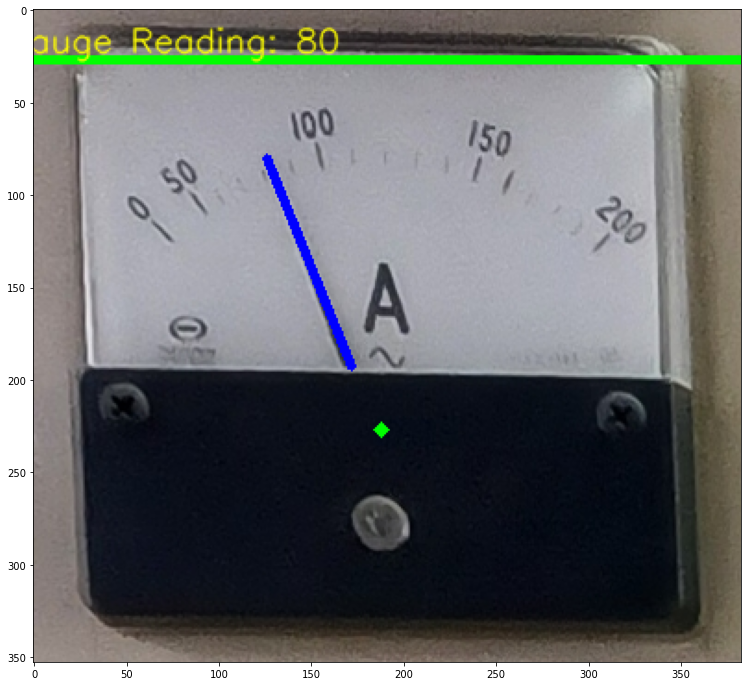

In [226]:
# 計算指針值
import math
output6 = img.copy()
old_min = float(min_angle)
old_max = float(max_angle)

new_min = float(min_value)
new_max = float(max_value)

old_value = final_angle

old_range = (old_max - old_min)
new_range = (new_max - new_min)
new_value = (((old_value - old_min) * new_range) / old_range) + new_min

print(f"Reading of the Gauge is {new_value}")

cv2.rectangle(output6, (int(x-(r+10)), int(y-(r+10))), (int(x+(r+10)),int(y+(r+10))), (0,255,0), 3)
cv2.putText(output6, ('Gauge Reading: {}'.format(math.ceil(new_value))), (int(x-(r+14)),int(y-(r+14))),
            cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255,255,0), 1, cv2.LINE_AA )
cv2.circle(output6, (int(x),int(y)), 2, (0,255,0), 3)
cv2.line(output6, (x1, y1), (x2, y2), (0, 0, 255), 3)

plt.figure(figsize=(15,12))
plt.imshow(output6)